In [137]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import numpy as np
from scipy import stats
from sklearn.isotonic import IsotonicRegression


In [138]:
# Load Data
df = pd.read_csv('data/email_marketing_campaign.csv')

In [139]:
# 1. Quick Data Check
print(f"Total Rows: {df.shape[0]}")
print(f"Segments: {df['segment'].unique()}")

Total Rows: 64000
Segments: ['Womens E-Mail' 'No E-Mail' 'Mens E-Mail']


In [140]:
# 2. Rename columns for clarity
# In Uplift modeling, we usually have:
# T (Treatment): Did they get the email?
# Y (Outcome): Did they convert?
df = df.rename(columns={'conversion': 'target_class'})

In [141]:
# 3. Create a binary 'treatment' flag for simpler analysis
# We will focus on 'Mens E-Mail' vs 'No E-Mail' first (ignore Womens for now)
df_men = df[df['segment'].isin(['Mens E-Mail', 'No E-Mail'])].copy()
df_men['treatment'] = df_men['segment'].apply(lambda x: 1 if x == 'Mens E-Mail' else 0)

In [142]:
print("\nData prepared for Men's Email Analysis.")
df_men.head()


Data prepared for Men's Email Analysis.


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,target_class,spend,treatment
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0,0


Feature Engineering

Control Conversion Rate: 0.5726%
Treated Conversion Rate: 1.2531%
------------------------------
ACTUAL UPLIFT: 0.6805% points


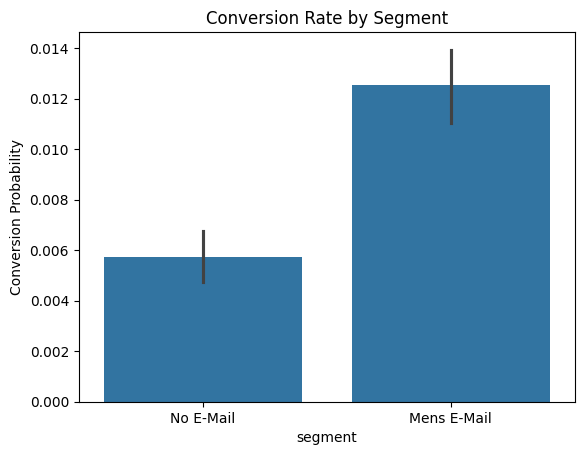

In [143]:
# Calculate Average conversion for Treated vs Control
uplift_summary = df_men.groupby('treatment')['target_class'].agg(['mean', 'sum', 'count'])
uplift_summary.columns = ['Conversion Rate', 'Total Conversions', 'Total Customers']

# Calculate the Lift (Difference)
control_conv = uplift_summary.loc[0, 'Conversion Rate']
treated_conv = uplift_summary.loc[1, 'Conversion Rate']
uplift = treated_conv - control_conv

print(f"Control Conversion Rate: {control_conv:.4%}")
print(f"Treated Conversion Rate: {treated_conv:.4%}")
print("-" * 30)
print(f"ACTUAL UPLIFT: {uplift:.4%} points")

# Visualize it
sns.barplot(x=df_men['segment'], y=df_men['target_class'])
plt.title("Conversion Rate by Segment")
plt.ylabel("Conversion Probability")
plt.show()

Model Training


In [144]:
# 1. Feature Engineering
# We need to convert text ('Rural', 'Web') into numbers for XGBoost
categorical_cols = ['zip_code', 'channel', 'history_segment']
df_model = pd.get_dummies(df_men, columns=categorical_cols, drop_first=True)

In [145]:
# Define X (Features), y (Outcome), and t (Treatment)
X = df_model.drop(['treatment', 'target_class', 'segment', 'visit', 'spend'], axis=1)
y = df_model['target_class']
t = df_model['treatment']

In [146]:
# 2. Split Data (Train vs Test)
# We hide 20% of data to test if our model actually works
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
    X, y, t, test_size=0.2, random_state=42, stratify=t
)

print(f"Training Data Shape: {X_train.shape}")

Training Data Shape: (34090, 15)


In [147]:
# 3. The T-Learner Architecture
# Separate the training data into 'Treated' and 'Control'
X_train_ctrl = X_train[t_train == 0]
y_train_ctrl = y_train[t_train == 0]

X_train_tr = X_train[t_train == 1]
y_train_tr = y_train[t_train == 1]

In [148]:
# 4. Train the Models 

model_ctrl = xgb.XGBClassifier(tree_method="hist", device="cuda", enable_categorical=True)
model_tr = xgb.XGBClassifier(tree_method="hist", device="cuda", enable_categorical=True)

print("Training Control Model...")
model_ctrl.fit(X_train_ctrl, y_train_ctrl)

print("Training Treatment Model...")
model_tr.fit(X_train_tr, y_train_tr)

Training Control Model...
Training Treatment Model...


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [149]:
# 5. Predict Uplift
# We ask BOTH models to predict for the TEST set
pred_ctrl = model_ctrl.predict_proba(X_test)[:, 1] # Probability of buying WITHOUT email
pred_tr = model_tr.predict_proba(X_test)[:, 1]     # Probability of buying WITH email

# Uplift = P(Buy | Email) - P(Buy | No Email)
uplift_score = pred_tr - pred_ctrl

# Add scores to a results dataframe
df_results = X_test.copy()
df_results['uplift_score'] = uplift_score
df_results['true_outcome'] = y_test
df_results['treatment'] = t_test

print("\nUplift Scores Calculated!")
print(df_results[['uplift_score']].head())


Uplift Scores Calculated!
       uplift_score
41663      0.000597
57162     -0.021197
23188      0.001651
8128      -0.016221
10916     -0.000015


/tmp/ipykernel_24374/1317879970.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uplift_by_decile = df_results.groupby('uplift_decile').apply(calculate_actual_lift).reset_index(name='actual_uplift')
/tmp/ipykernel_24374/1317879970.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='uplift_decile', y='actual_uplift', data=uplift_by_decile, palette="viridis")


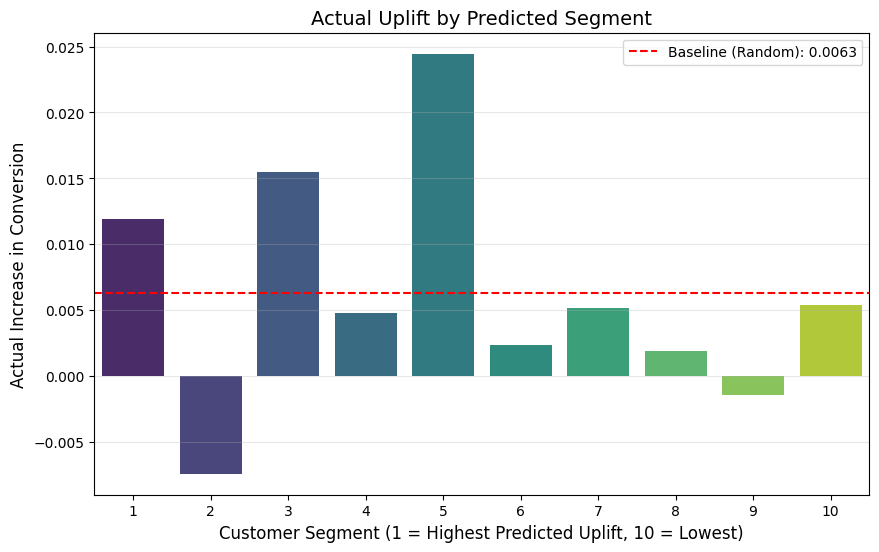

In [150]:
# 1. Segment users into Deciles (Top 10% best scores, etc.)
# We want 10 bins, labeled 1 (Top) to 10 (Bottom)
df_results['uplift_decile'] = pd.qcut(df_results['uplift_score'], 10, labels=False, duplicates='drop')
df_results['uplift_decile'] = 10 - df_results['uplift_decile'] # Reverse so 1 is Top

# 2. Calculate Actual Uplift per Decile
# For each bin, we manually calculate: (Conversion | Treated) - (Conversion | Control)
def calculate_actual_lift(group):
    control_conv = group[group['treatment'] == 0]['true_outcome'].mean()
    treated_conv = group[group['treatment'] == 1]['true_outcome'].mean()
    return treated_conv - control_conv

uplift_by_decile = df_results.groupby('uplift_decile').apply(calculate_actual_lift).reset_index(name='actual_uplift')

# 3. Plot the "Money Chart"
plt.figure(figsize=(10, 6))
sns.barplot(x='uplift_decile', y='actual_uplift', data=uplift_by_decile, palette="viridis")

# Add a red line for the "Average Uplift" (Random Emailing)
avg_uplift = df_results[df_results['treatment']==1]['true_outcome'].mean() - df_results[df_results['treatment']==0]['true_outcome'].mean()
plt.axhline(y=avg_uplift, color='r', linestyle='--', label=f'Baseline (Random): {avg_uplift:.4f}')

plt.title("Actual Uplift by Predicted Segment", fontsize=14)
plt.xlabel("Customer Segment (1 = Highest Predicted Uplift, 10 = Lowest)", fontsize=12)
plt.ylabel("Actual Increase in Conversion", fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [151]:
# Calculate Bootstrap Confidence Intervals
from scipy import stats
import numpy as np

def bootstrap_uplift(group, n_bootstrap=1000):
    """Calculate uplift with 95% confidence interval"""
    uplifts = []
    for _ in range(n_bootstrap):
        sample = group.sample(n=len(group), replace=True)
        control = sample[sample['treatment']==0]['true_outcome'].mean()
        treated = sample[sample['treatment']==1]['true_outcome'].mean()
        uplifts.append(treated - control)
    
    ci_low = np.percentile(uplifts, 2.5)
    ci_high = np.percentile(uplifts, 97.5)
    return np.mean(uplifts), ci_low, ci_high

In [152]:
#Calculate for each decile
results = []
for decile in range(1, 11):
    group = df_results[df_results['uplift_decile'] == decile]
    uplift, ci_low, ci_high = bootstrap_uplift(group)
    results.append({
        'decile': decile,
        'uplift': uplift,
        'ci_low': ci_low,
        'ci_high': ci_high
    })

In [153]:
#Convert to DataFrame (THIS WAS MISSING)
results_df = pd.DataFrame(results)


In [154]:
#Calculate error bar values
yerr_low = results_df['uplift'] - results_df['ci_low']
yerr_high = results_df['ci_high'] - results_df['uplift']

✅ Chart saved to assets/uplift_with_ci.png


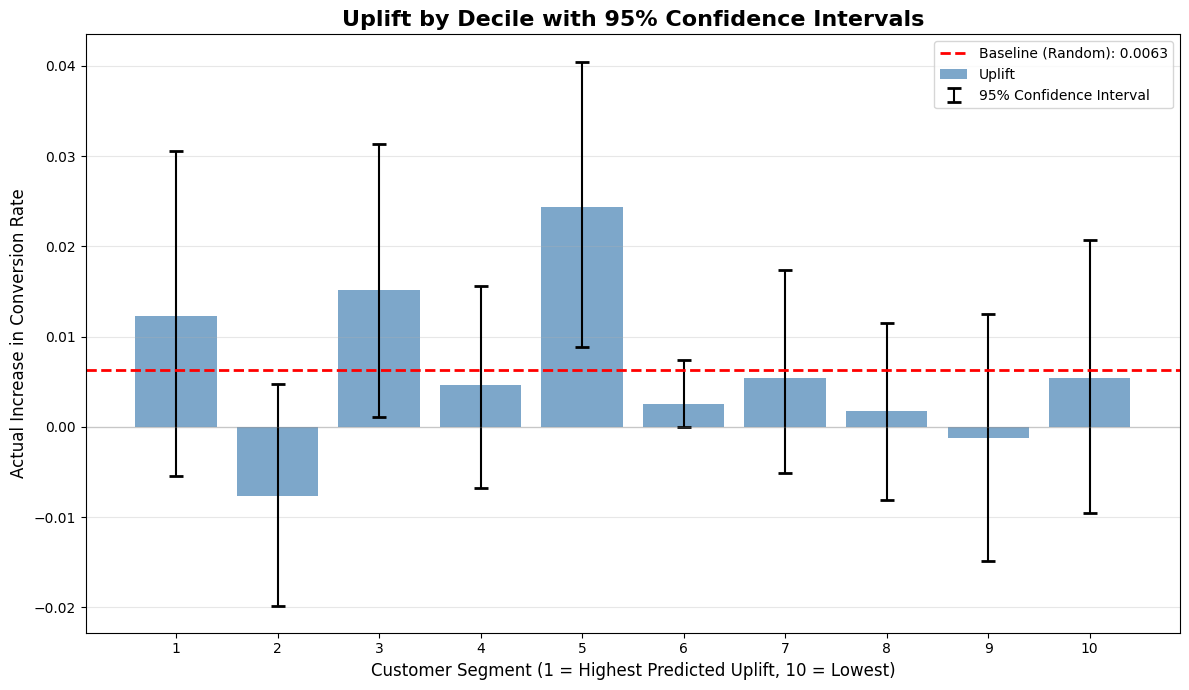

In [155]:
# Plot with error bars
plt.figure(figsize=(12, 7))

# Bar plot
plt.bar(results_df['decile'], results_df['uplift'], 
        color='steelblue', alpha=0.7, label='Uplift')

# Add error bars
plt.errorbar(results_df['decile'], results_df['uplift'], 
             yerr=[yerr_low, yerr_high],
             fmt='none', ecolor='black', capsize=5, capthick=2,
             label='95% Confidence Interval')

# Baseline (average uplift from random targeting)
avg_uplift = df_results[df_results['treatment']==1]['true_outcome'].mean() - \
             df_results[df_results['treatment']==0]['true_outcome'].mean()
plt.axhline(y=avg_uplift, color='red', linestyle='--', linewidth=2,
            label=f'Baseline (Random): {avg_uplift:.4f}')

# Zero line (no effect)
plt.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.3)

# Labels and styling
plt.title("Uplift by Decile with 95% Confidence Intervals", fontsize=16, fontweight='bold')
plt.xlabel("Customer Segment (1 = Highest Predicted Uplift, 10 = Lowest)", fontsize=12)
plt.ylabel("Actual Increase in Conversion Rate", fontsize=12)
plt.xticks(range(1, 11))
plt.legend(loc='best', fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Save BEFORE showing
import os
if not os.path.exists('assets'):
    os.makedirs('assets')
plt.savefig('assets/uplift_with_ci.png', dpi=300, bbox_inches='tight')
print("✅ Chart saved to assets/uplift_with_ci.png")

# Show AFTER saving
plt.show()

In [156]:
#Print the results table
print("\nUplift by Decile with Confidence Intervals:")
print("="*70)
results_df['ci_range'] = results_df['ci_high'] - results_df['ci_low']
results_df['significant'] = ~((results_df['ci_low'] < 0) & (results_df['ci_high'] > 0))
print(results_df.to_string(index=False))
print("\n Deciles with significant positive uplift:", 
      results_df[results_df['significant'] & (results_df['uplift'] > 0)]['decile'].tolist())


Uplift by Decile with Confidence Intervals:
 decile    uplift    ci_low  ci_high  ci_range  significant
      1  0.012245 -0.005501 0.030539  0.036040        False
      2 -0.007652 -0.019808 0.004741  0.024549        False
      3  0.015140  0.001130 0.031390  0.030260         True
      4  0.004588 -0.006734 0.015556  0.022290        False
      5  0.024351  0.008853 0.040477  0.031624         True
      6  0.002470  0.000000 0.007426  0.007426         True
      7  0.005420 -0.005124 0.017413  0.022537        False
      8  0.001801 -0.008062 0.011468  0.019530        False
      9 -0.001287 -0.014914 0.012498  0.027412        False
     10  0.005355 -0.009507 0.020661  0.030168        False

 Deciles with significant positive uplift: [3, 5, 6]


In [157]:
# BUSINESS IMPACT ANALYSIS


print("ACTIONABLE INSIGHTS\n" )

# 1. Identify profitable segments
profitable_deciles = results_df[
    (results_df['significant']) & 
    (results_df['uplift'] > 0)
]['decile'].tolist()

print(f"\n Target These Segments: Deciles {profitable_deciles}")
print(f"   - Combined Uplift: {results_df[results_df['decile'].isin(profitable_deciles)]['uplift'].mean():.4f}")

# 2. Calculate potential customers
total_customers = len(df_results)
customers_per_decile = total_customers / 10

target_customers = len(profitable_deciles) * customers_per_decile

print(f"\n Targeting Strategy:")
print(f"   - Random Targeting: {total_customers:,.0f} customers")
print(f"   - Smart Targeting: {target_customers:,.0f} customers ({target_customers/total_customers*100:.1f}%)")
print(f"   - Reduction: {(total_customers - target_customers)/total_customers*100:.1f}% fewer emails")

# 3. Uplift comparison
random_uplift = df_results[df_results['treatment']==1]['true_outcome'].mean() - \
                df_results[df_results['treatment']==0]['true_outcome'].mean()

target_uplift = results_df[results_df['decile'].isin(profitable_deciles)]['uplift'].mean()

print(f"\n Performance Improvement:")
print(f"   - Random Uplift: {random_uplift:.4f} ({random_uplift*100:.2f}%)")
print(f"   - Targeted Uplift: {target_uplift:.4f} ({target_uplift*100:.2f}%)")
print(f"   - Improvement: {(target_uplift/random_uplift - 1)*100:.1f}%")

# 4. Statistical power
print(f"\n Model Quality:")
print(f"   - Significant Deciles: {len(profitable_deciles)}/10")
print(f"   - Average CI Width: {results_df['ci_range'].mean():.4f}")
print(f"   - Max Uplift: Decile {results_df.loc[results_df['uplift'].idxmax(), 'decile']:.0f} "
      f"({results_df['uplift'].max():.4f})")

ACTIONABLE INSIGHTS


 Target These Segments: Deciles [3, 5, 6]
   - Combined Uplift: 0.0140

 Targeting Strategy:
   - Random Targeting: 8,523 customers
   - Smart Targeting: 2,557 customers (30.0%)
   - Reduction: 70.0% fewer emails

 Performance Improvement:
   - Random Uplift: 0.0063 (0.63%)
   - Targeted Uplift: 0.0140 (1.40%)
   - Improvement: 120.8%

 Model Quality:
   - Significant Deciles: 3/10
   - Average CI Width: 0.0252
   - Max Uplift: Decile 5 (0.0244)
